In [1]:
# %load withholding.py
# %matplotlib notebook
import matplotlib as plt
import numpy as np
import pandas as pd

import seaborn as sns

# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/withholding.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except:
        return np.array([float("nan")])


def expand(row):
    compute = parse_array(row.compute)
    rcompute = compute / np.sum(compute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / row.number_activations
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    d = {}
    d["attack_space"] = row["strategy"].split("-")[0]
    d["policy"] = "-".join(row["strategy"].split("-")[1:])
    d["attacker_compute"] = rcompute[0]
    d["attacker_relative_activations"] = ractivations[0]
    d["attacker_relative_reward"] = rreward[0]
    d["attacker_gain"] = rreward[0] - ractivations[0]
    d["attacker_reward"] = reward[0]
    d["attacker_reward_per_time"] = reward[0] / row.ca_time
    # simulate DAA restrospectively. This method works only for zero network delays.
    d["da_observed_pow_interval"] = row.ca_time / (row.ca_height * row.k)
    d["da_target_pow_interval"] = 1
    d["da_ca_time"] = (
        row.ca_time / d["da_observed_pow_interval"] * d["da_target_pow_interval"]
    )
    d["da_attacker_reward_per_time"] = reward[0] / d["da_ca_time"]
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

d = df[df.protocol == "tailstormll"]
d = d[(d.incentive_scheme == "constant") | (d.incentive_scheme == "discount")]
d.columns

Index(['network', 'network_description', 'compute', 'protocol', 'k',
       'protocol_description', 'block_interval', 'activation_delay',
       'number_activations', 'activations', 'incentive_scheme',
       'incentive_scheme_description', 'strategy', 'strategy_description',
       'reward', 'ca_time', 'ca_height', 'machine_duration_s', 'error',
       'version', 'attack_space', 'policy', 'attacker_compute',
       'attacker_relative_activations', 'attacker_relative_reward',
       'attacker_gain', 'attacker_reward', 'attacker_reward_per_time',
       'da_observed_pow_interval', 'da_target_pow_interval', 'da_ca_time',
       'da_attacker_reward_per_time'],
      dtype='object')

In [2]:
d.pivot(
    index=["network", "attacker_compute", "k"],
    columns=["strategy", "incentive_scheme"],
    values="attacker_relative_reward",
)

strategy                              ssz-override-catchup ssz-override-block  \
incentive_scheme                                  constant           constant   
network           attacker_compute k                                            
gamma-0-alpha-0.1 0.1              1              0.037933           0.034166   
                                   2              0.022832           0.022383   
                                   4              0.019623           0.019824   
                                   8              0.015132           0.014667   
                                   16             0.015431           0.015708   
...                                                    ...                ...   
two-agents-0.5    0.5              2              0.851347           0.579101   
                                   4              0.910954           0.604437   
                                   8              0.852660           0.621343   
                                   16             0.819352           0.655978   
                                   32             0.909501           0.681708   

strategy                              ssz-release-block ssz-honest  \
incentive_scheme                               constant   constant   
network           attacker_compute k                                 
gamma-0-alpha-0.1 0.1              1           0.100100   0.094340   
                                   2           0.065500   0.100583   
                                   4           0.049915   0.102900   
                                   8           0.034227   0.098800   
                                   16          0.048060   0.103900   
...                                                 ...        ...   
two-agents-0.5    0.5              2           0.496194   0.498070   
                                   4           0.522230   0.503900   
                                   8           0.535841   0.489400   
                                   16          0.525829   0.498900   
                                   32          0.510658   0.504808   

strategy                              ssz-override-catchup ssz-override-block  \
incentive_scheme                                  discount           discount   
network           attacker_compute k                                            
gamma-0-alpha-0.1 0.1              1              0.034122           0.037227   
                                   2              0.021744           0.028468   
                                   4              0.015871           0.012075   
                                   8              0.017209           0.015188   
                                   16             0.011055           0.012693   
...                                                    ...                ...   
two-agents-0.5    0.5              2              0.812328           0.587141   
                                   4              0.869400           0.605308   
                                   8              0.925681           0.616535   
                                   16             0.850784           0.671440   
                                   32             0.922803           0.656995   

strategy                              ssz-release-block ssz-honest  \
incentive_scheme                               discount   discount   
network           attacker_compute k                                 
gamma-0-alpha-0.1 0.1              1           0.098900   0.087250   
                                   2           0.063688   0.096629   
                                   4           0.042760   0.098687   
                                   8           0.038953   0.098659   
                                   16          0.035458   0.099784   
...                                                 ...        ...   
two-agents-0.5    0.5              2           0.495387   0.510296   
                                   4           0.

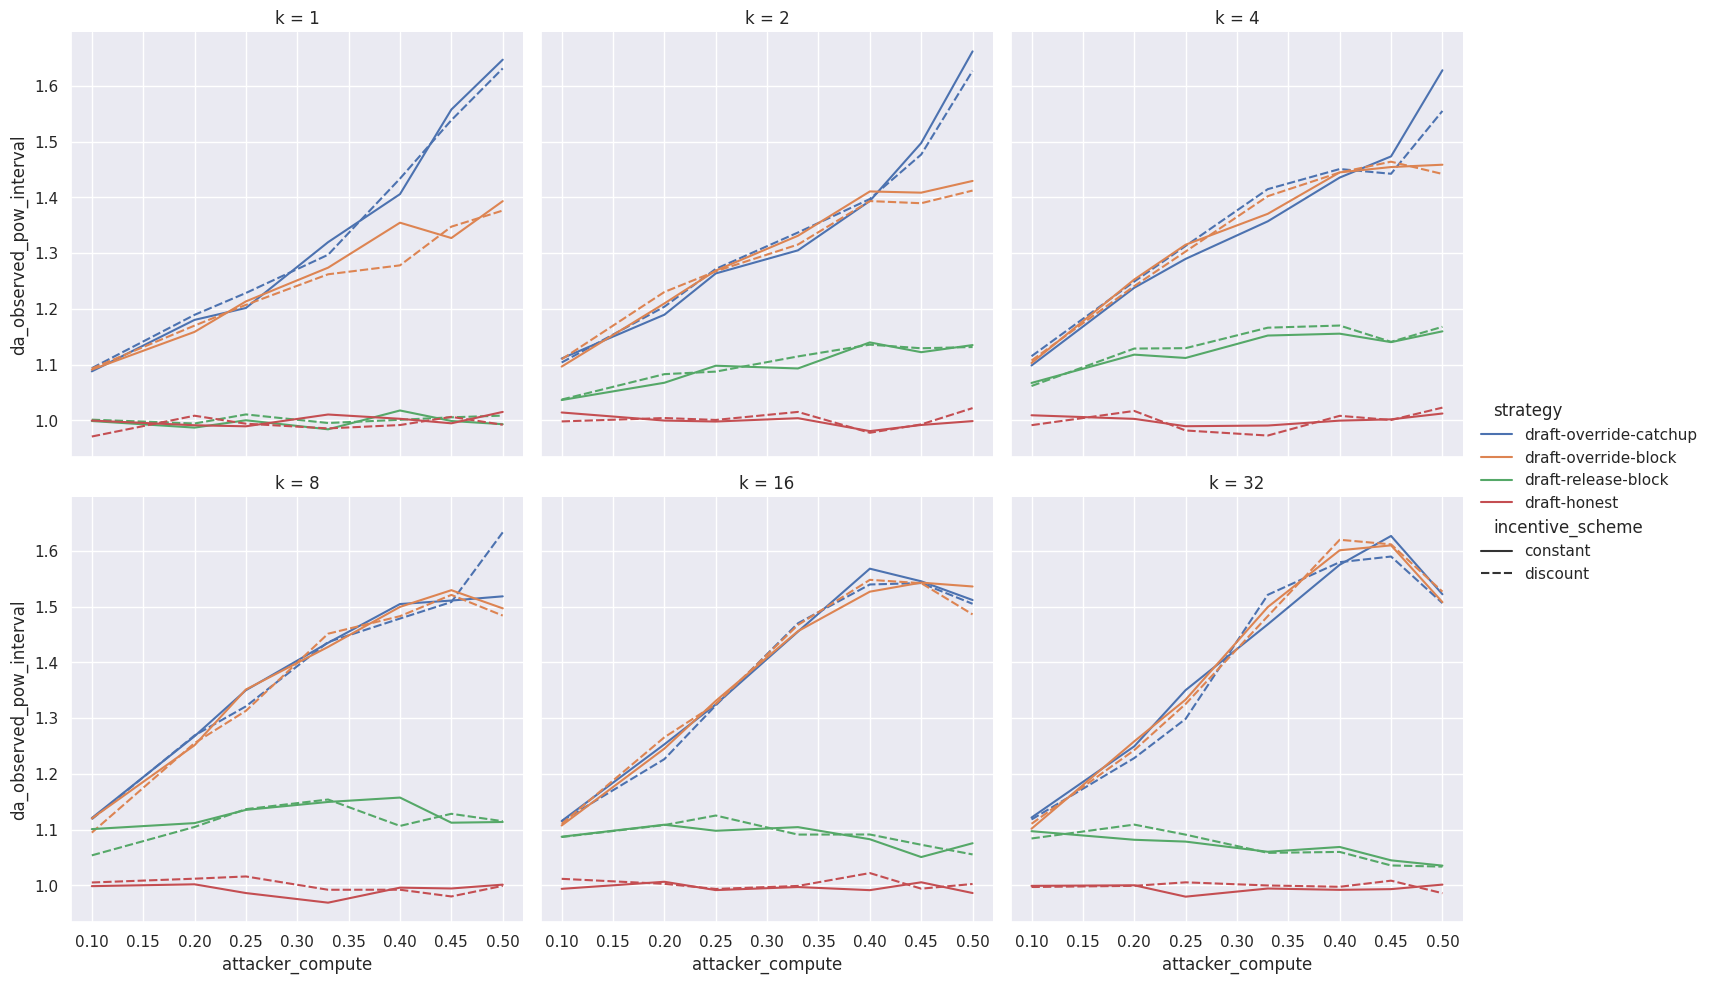

In [3]:
ax = sns.relplot(
    data=d[d.attack_space == "draft"],
    x="attacker_compute",
    y="da_observed_pow_interval",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)

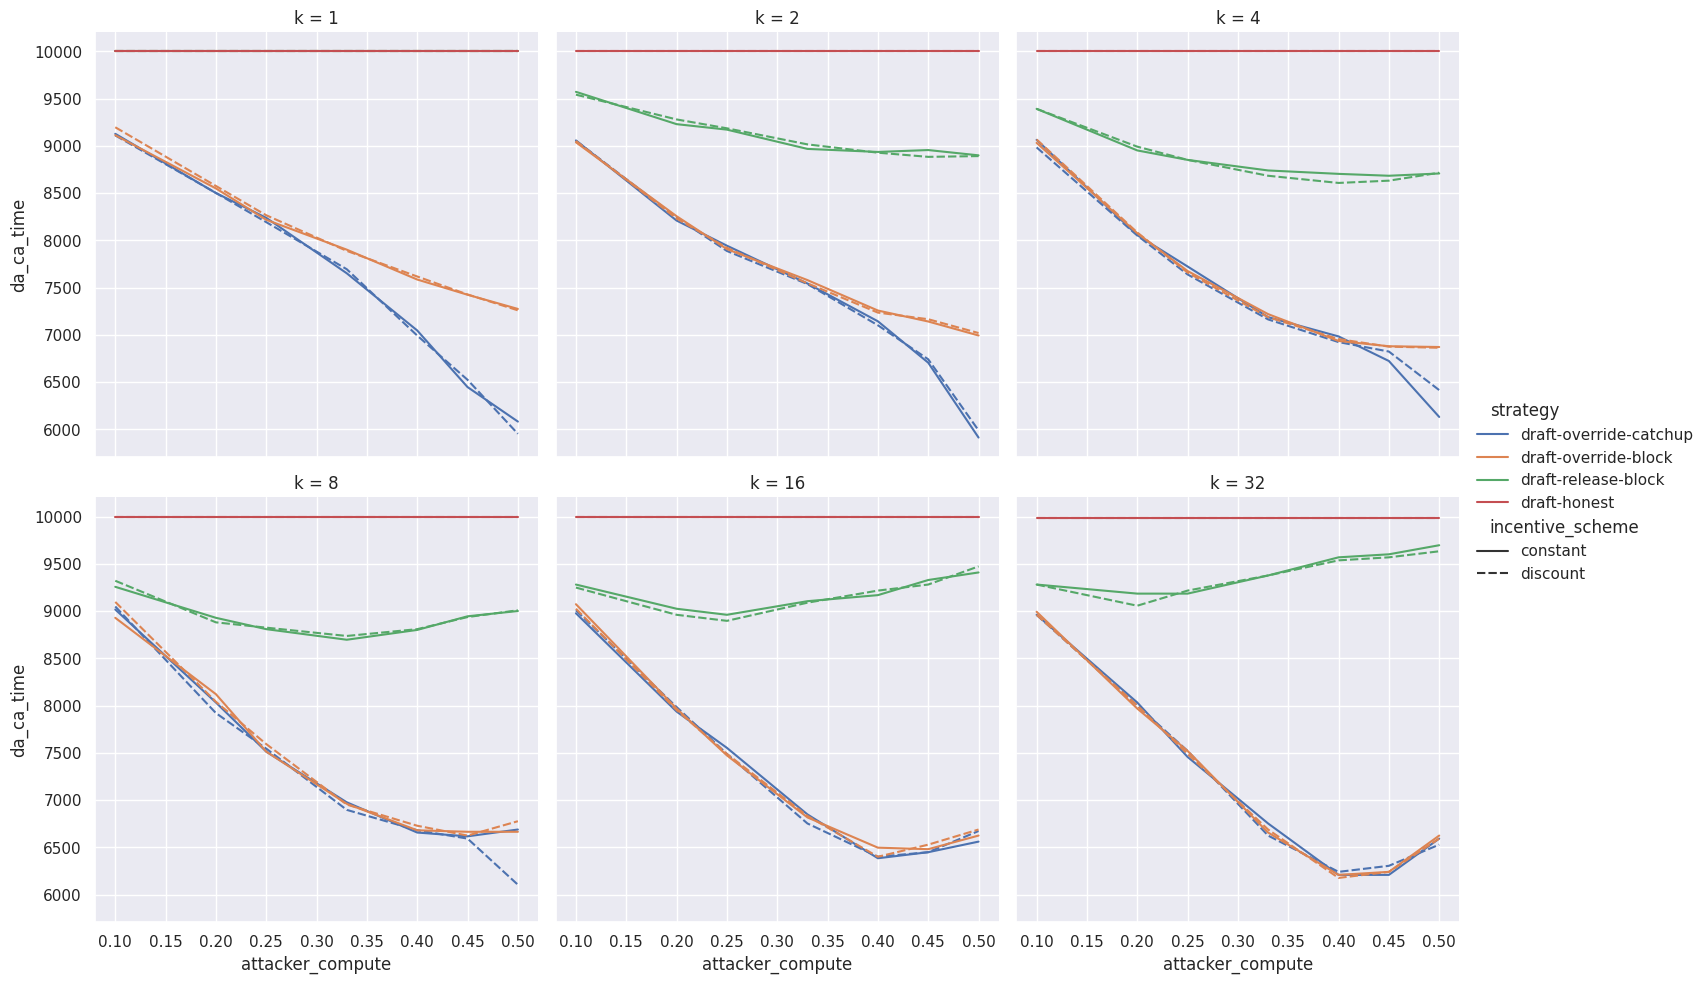

In [4]:
ax = sns.relplot(
    data=d[d.attack_space == "draft"],
    x="attacker_compute",
    y="da_ca_time",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)

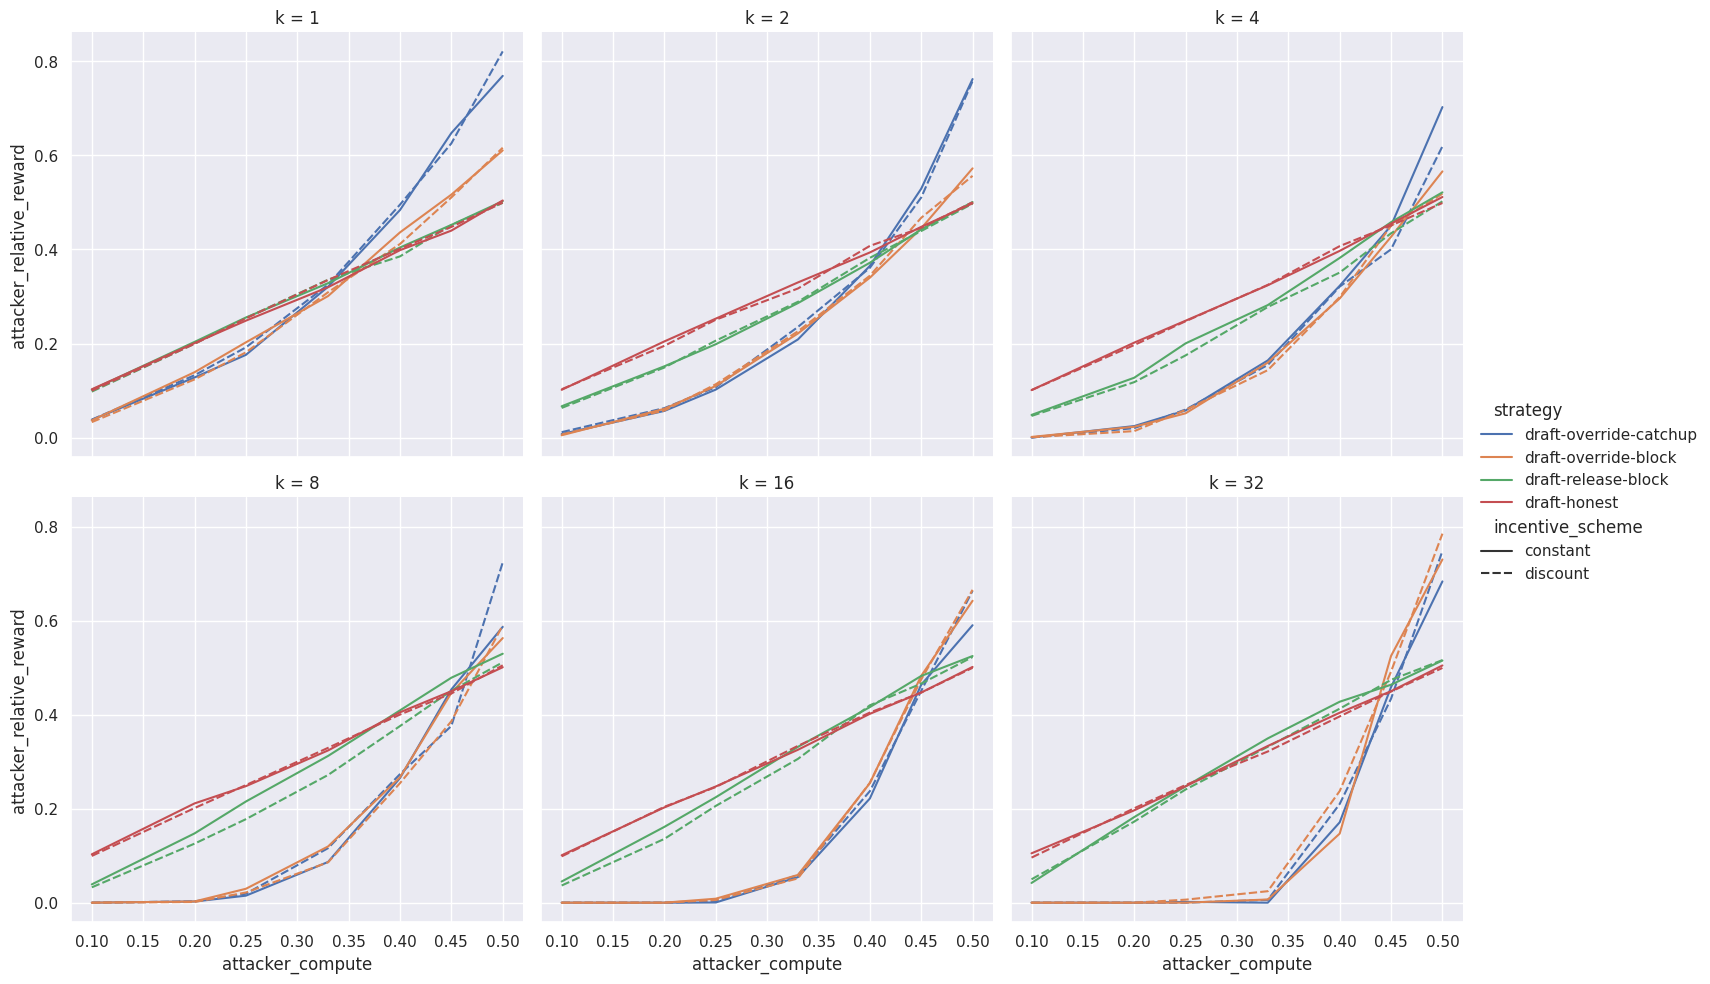

In [5]:
ax = sns.relplot(
    data=d[d.attack_space == "draft"],
    x="attacker_compute",
    y="attacker_relative_reward",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_relative.png")

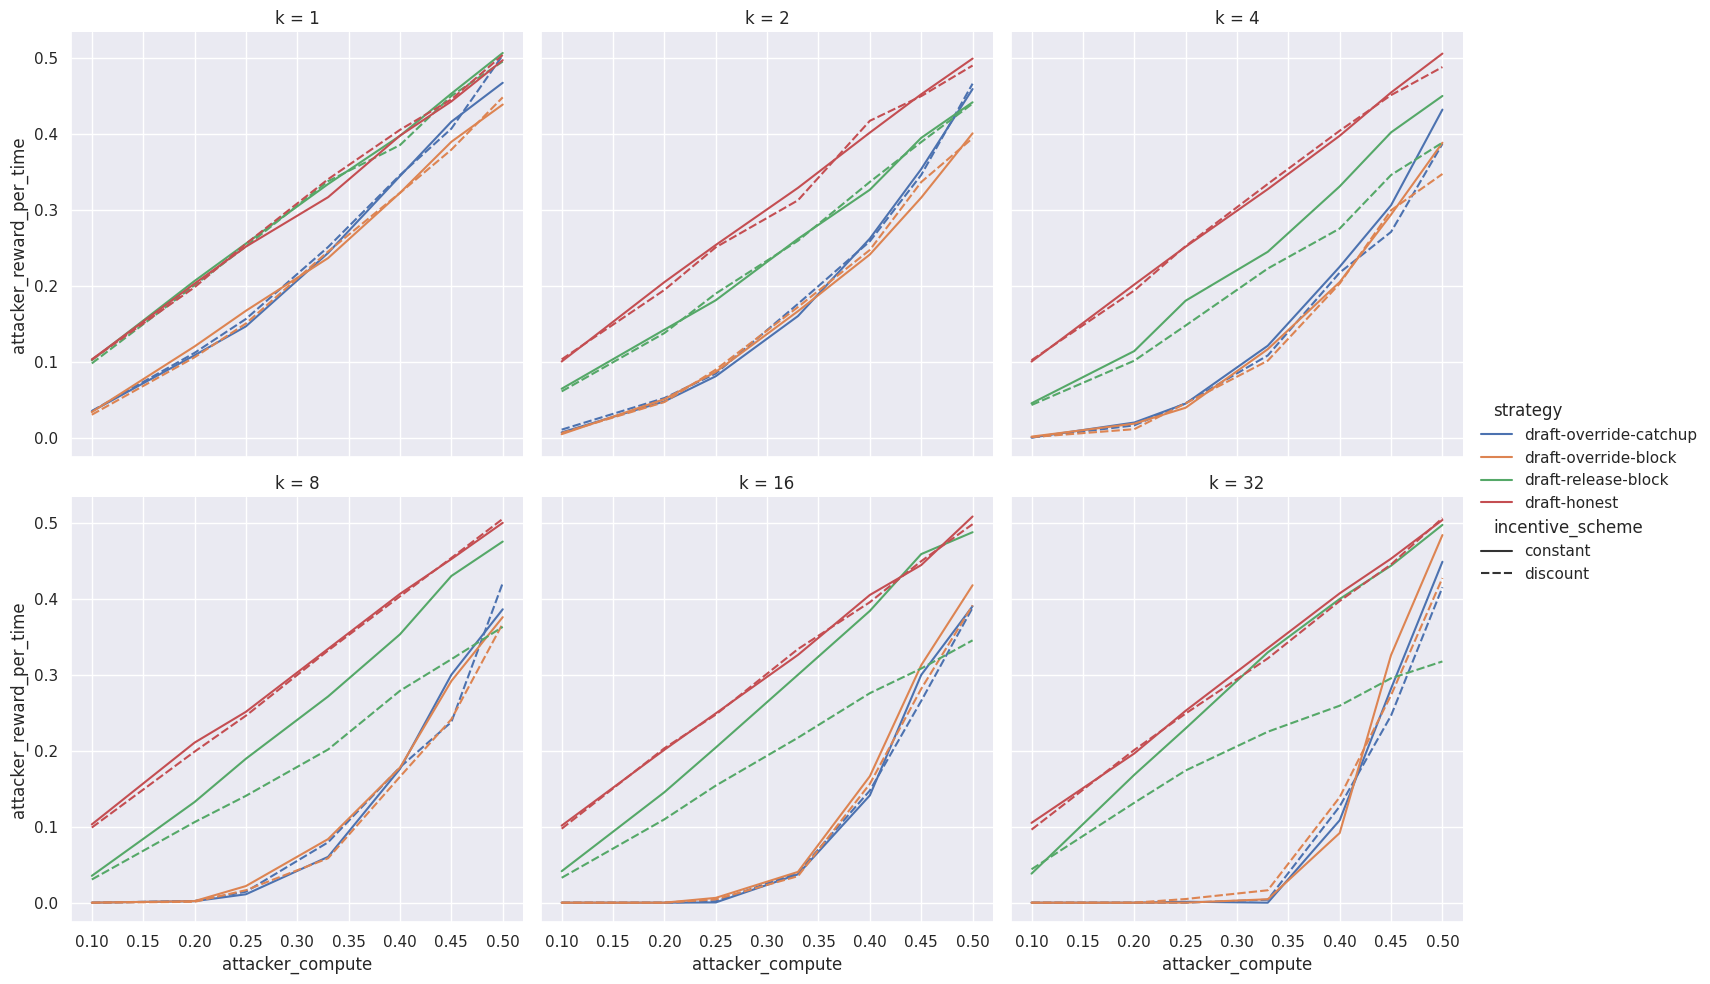

In [6]:
ax = sns.relplot(
    data=d[d.attack_space == "draft"],
    x="attacker_compute",
    y="attacker_reward_per_time",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_absolute.png")

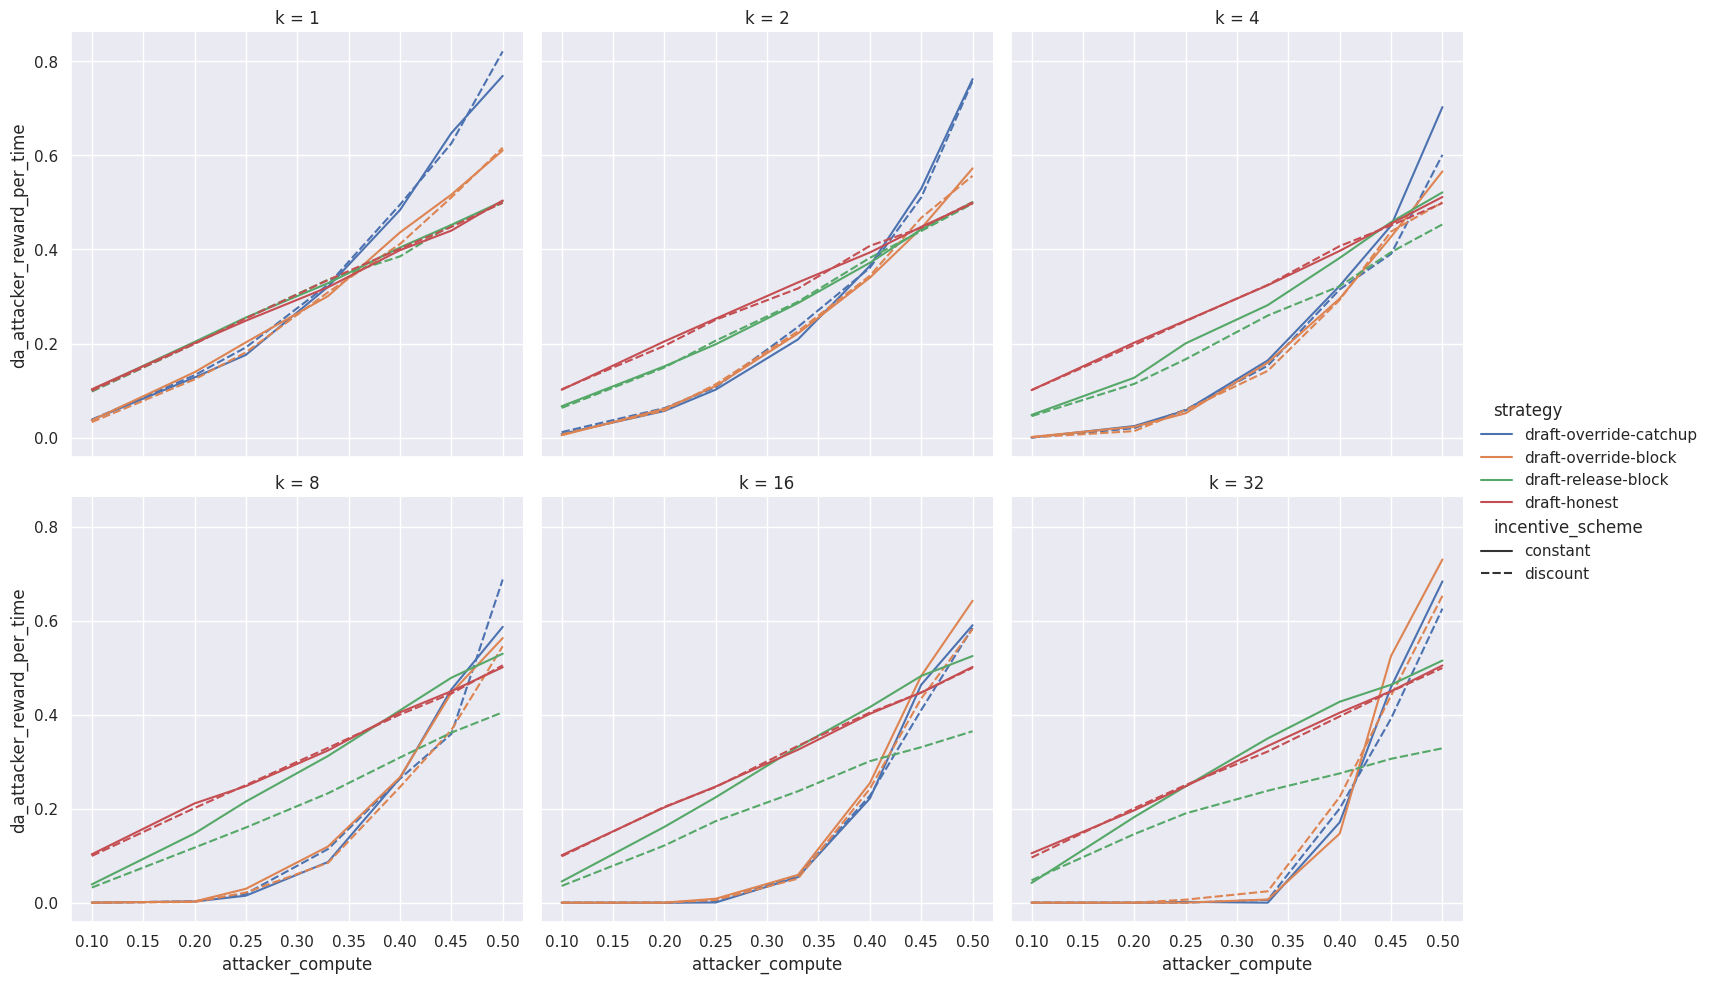

In [7]:
ax = sns.relplot(
    data=d[d.attack_space == "draft"],
    x="attacker_compute",
    y="da_attacker_reward_per_time",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_daa.png")

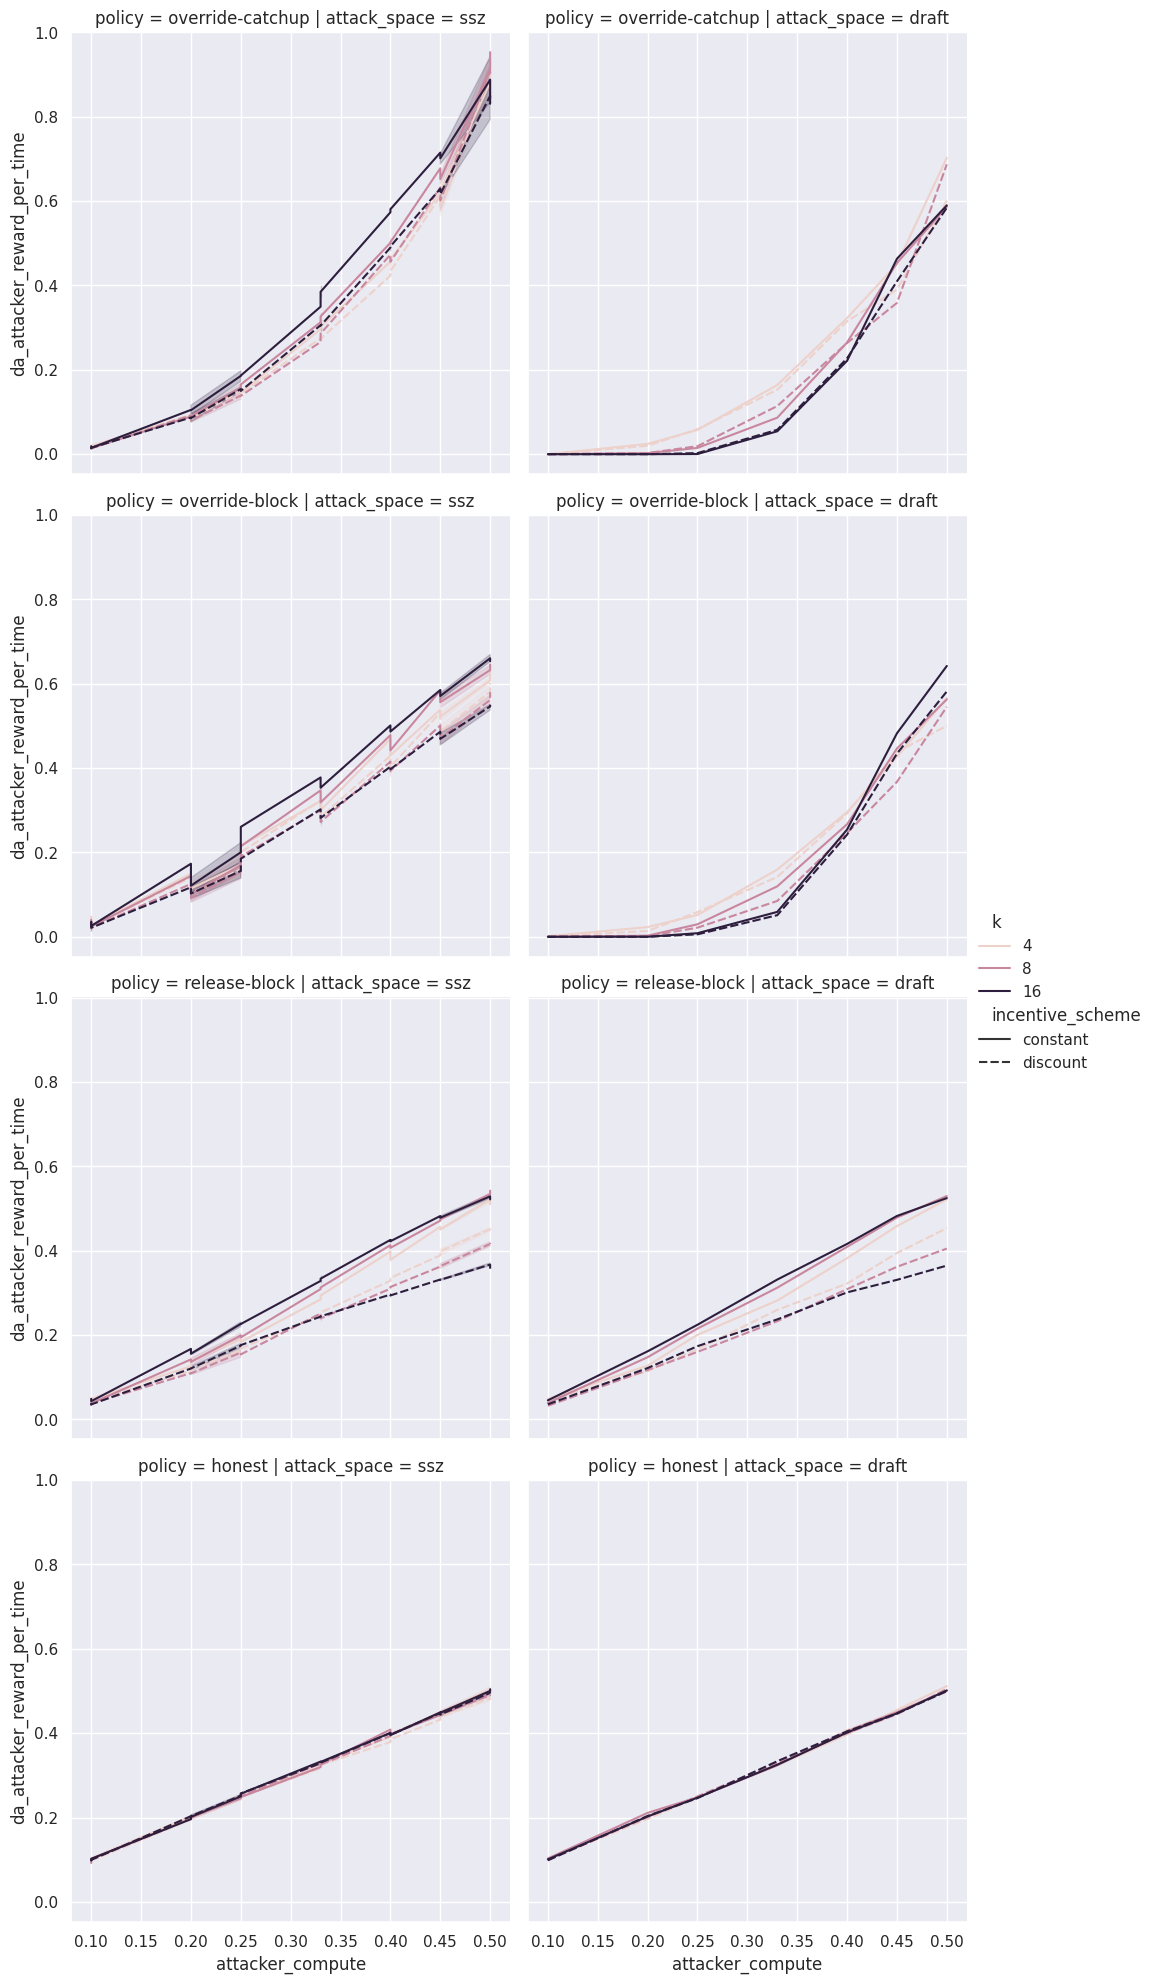

In [8]:
ax = sns.relplot(
    data=d[[k in [4, 8, 16] for k, policy in zip(d.k, d.policy)]],
    x="attacker_compute",
    y="da_attacker_reward_per_time",
    col="attack_space",
    row="policy",
    hue="k",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_daa.png")